<a href="https://colab.research.google.com/github/harshaharod21/blaze-quant-challenge/blob/main/Time_series_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install --upgrade xgboost

In [ ]:
! pip install optuna xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.5 MB/s eta 0:00:00


In [ ]:
! pip install optuna

In [80]:
#Importing all the important libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
import matplotlib.dates as mdates
import sklearn
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
import optuna
from sklearn.model_selection import TimeSeriesSplit





In [81]:
#Loading the file

file_path ='/content/jena_climate_2009_2016.csv'
climate_df=pd.read_csv(file_path)

#Some general info about data
print(climate_df.shape)
print(climate_df.columns)
print( climate_df.isnull().sum())


(420451, 15)
Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')
Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64


* Total rows: 4,20,451
* Total columne: 15
* Missing values: 0










> The data is from 01.01.2009 to 01.01.2017







In [82]:
climate_df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


## Time series plot

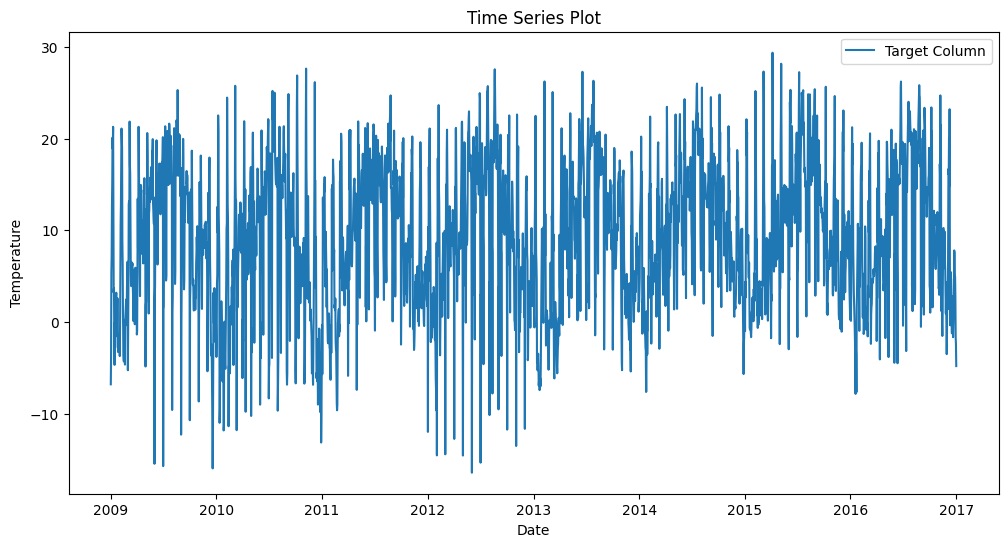

In [83]:


climate_df['Date Time'] = pd.to_datetime(climate_df['Date Time'])

climate_df.set_index('Date Time', inplace=True)

climate_df_resampled = climate_df.resample('D').mean()  # 'D' stands for daily

plt.figure(figsize=(12, 6))
sns.lineplot(x=climate_df_resampled.index, y=climate_df_resampled['T (degC)'], label='Target Column')
# You can add other variables as well
# sns.lineplot(x=df_resampled.index, y=df_resampled['other_variable'], label='Other Variable')

plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()


### Seaonal Decomposition

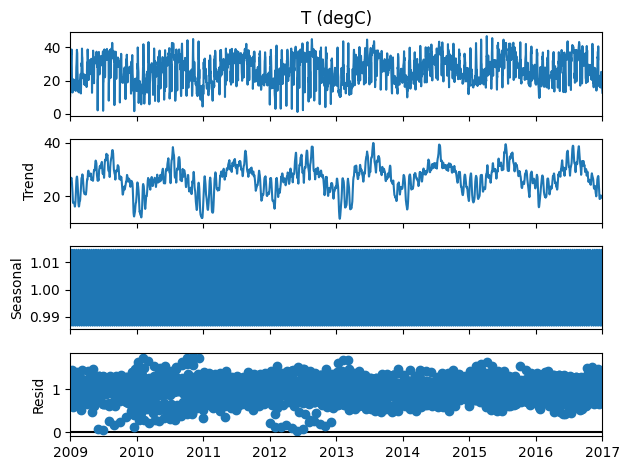

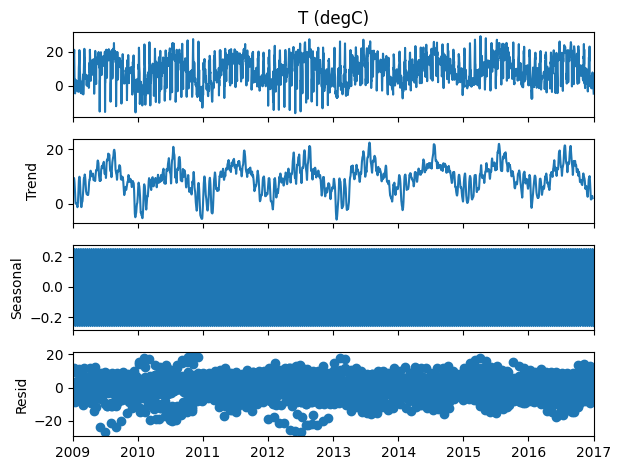

In [84]:
climate_na=climate_df_resampled.dropna()
climate_na.index = pd.to_datetime(climate_na.index)
from statsmodels.tsa.seasonal import seasonal_decompose
# Multiplicative Decomposition
#mul_decompose = seasonal_decompose(climate_na['T (degC)'], model='multiplicative', period=12)
constant_value = abs(climate_na['T (degC)'].min()) + 1  # You can adjust this constant based on your data
temperature_data_adjusted = climate_na['T (degC)'] + constant_value
result = seasonal_decompose(temperature_data_adjusted, model='multiplicative', period=12)
result.plot()
# Additive Decomposition
add_decompose = seasonal_decompose(climate_na['T (degC)'], model='additive', period=12)
#add_decompose.plot()
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot the components for visual inspection
add_decompose.plot()
plt.show()


### Residual plot

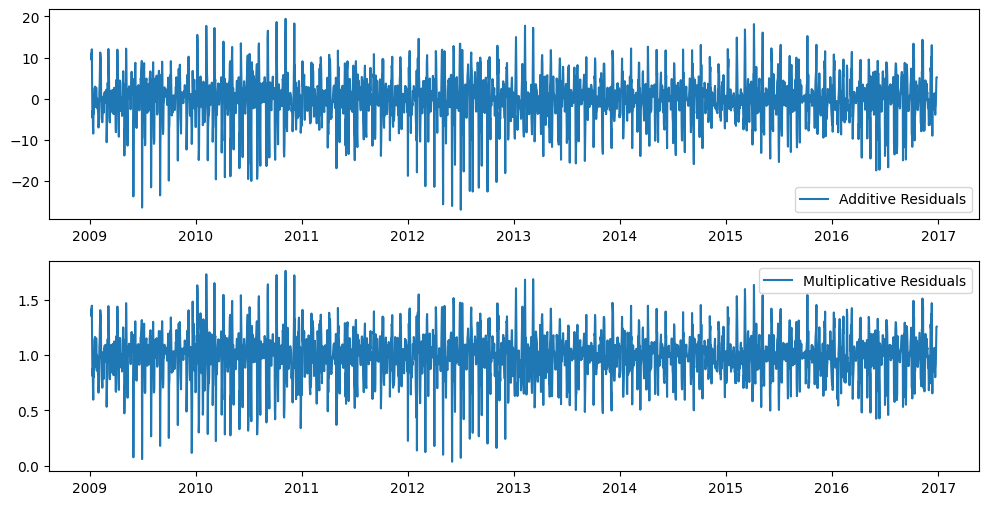

In [85]:
climate_na=climate_df_resampled.dropna()
climate_na.index = pd.to_datetime(climate_na.index)
result_additive = seasonal_decompose(climate_na['T (degC)'], model='additive',period=12)
constant_value = abs(climate_na['T (degC)'].min()) + 1  # You can adjust this constant based on your data
temperature_data_adjusted = climate_na['T (degC)'] + constant_value
result_multiplicative = seasonal_decompose(temperature_data_adjusted, model='multiplicative',period=12)

# Access the residuals
residual_additive = result_additive.resid
residual_multiplicative = result_multiplicative.resid

# Plot the residuals for both decompositions
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(residual_additive, label='Additive Residuals')
plt.legend()

plt.subplot(212)
plt.plot(residual_multiplicative, label='Multiplicative Residuals')
plt.legend()

plt.show()

#for non null value run,do it without removing nullvalue

Both additive and multiplicative model show similar patterns.
The residual graph indicates higher degree of variability in the mid years compared to early and later years in the given series.
* **Why both additive and multiplicative residuals are similar?**


* If there is a clear seasonal pattern, models that incorporate seasonality (e.g., SARIMA or Prophet) might be appropriate.But our dataset is multivariate.








Using STL to overcome the previous decomposition issue


*   STL decomposition is well-suited for time series with non-linear trends.
*   Anomaly detection: Residual will help us detect anomaly
*   Can help us decide if traditional model like ARIMA,SARIMA are good enough to model our data.If any complexity is observed (in terms of pattern) then we have to consider more advanced model like ML and deep learning.

### STL Decomposition

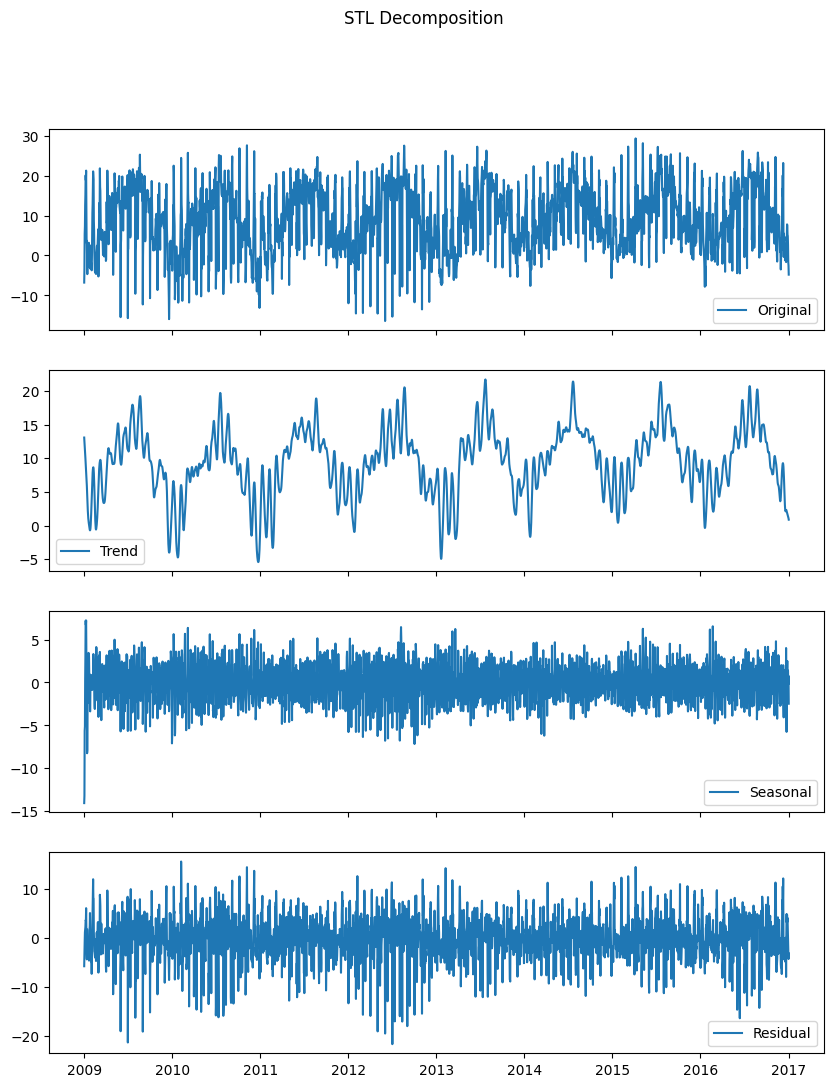

In [86]:
stl = STL(climate_na['T (degC)'], period=12) #seasonal=13
res = stl.fit()

# Plot the original time series and the decomposition components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

ax1.plot(climate_na['T (degC)'], label='Original')
ax1.legend()

ax2.plot(res.trend, label='Trend')
ax2.legend()

ax3.plot(res.seasonal, label='Seasonal')
ax3.legend()

ax4.plot(res.resid, label='Residual')
ax4.legend()

plt.suptitle('STL Decomposition')
plt.show()

* Here we can observe that the **residual** shows high variability ,so we need to consider  ML models ,like XGboost,phrophet and deeplearning models like LSTM for handling the complexity.
* We also need to remember that we are dealing with a **multivariate** dataset.


# **EDA**

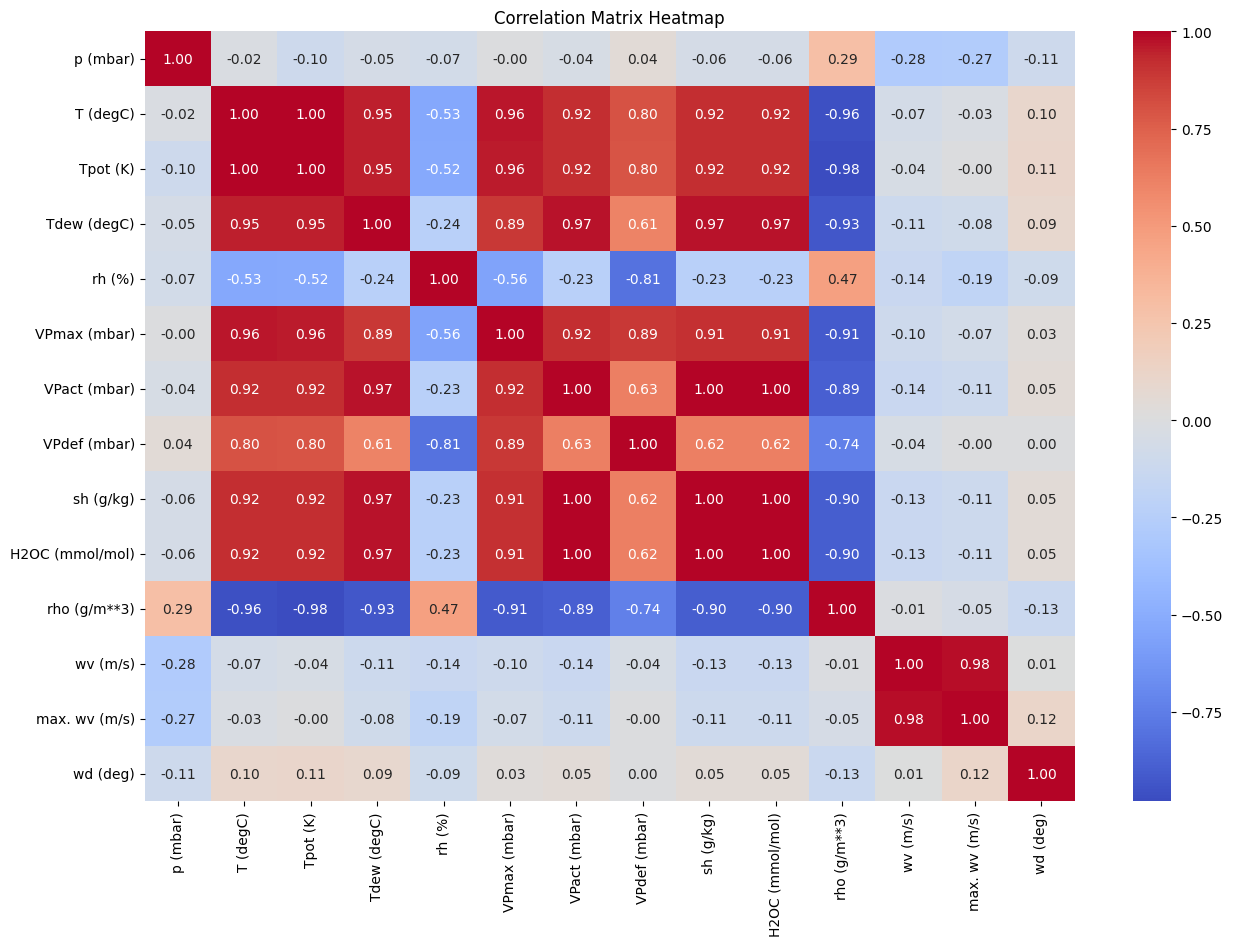

In [87]:


# Calculate the correlation matrix
correlation_matrix = climate_na.corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

* Herewe notice that p(mbar),wd(deg) and the wv (wind speed) are **weakly** correlated to target variable temperature.
* We can drop the less correlated features to avoid overfitting

# Line Plot
**How all the variables vary with time**

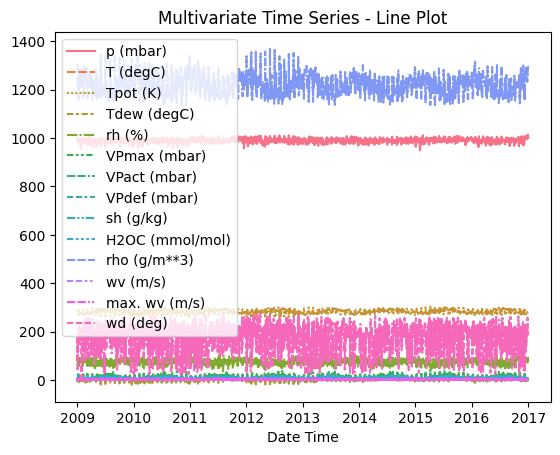

In [88]:
sns.lineplot(data=climate_na)
plt.title('Multivariate Time Series - Line Plot')
plt.show()

# Data preprocessing

In [89]:
#Removing the features which are less correlated to target variable

columns_to_drop = ['p (mbar)', 'wd (deg)', 'wv (m/s)', 'max. wv (m/s)']
climate_na = climate_na.drop(columns=columns_to_drop)

# **XGBoost ML Model**




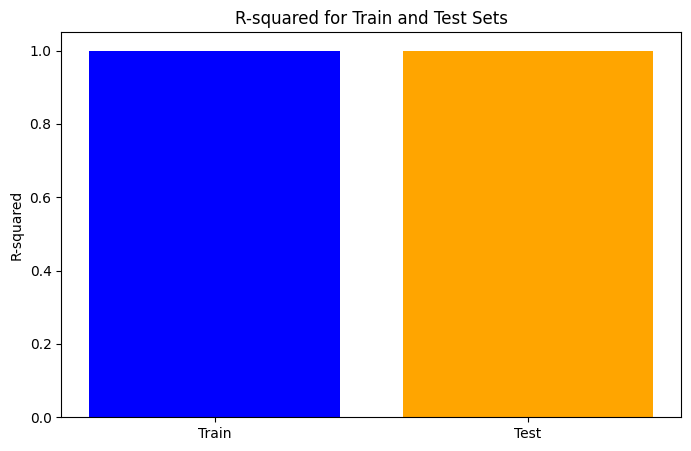

R2 for train dataset 0.9999733346675982
R2 for test dataset 0.9991738632258305


In [90]:
#Training the base model

X=climate_na[[ 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)','H2OC (mmol/mol)', 'rho (g/m**3)']]
Y=climate_na['T (degC)']
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, shuffle=False, test_size=0.3)

model=XGBRegressor()
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

#To plot R2 for train and test
plt.figure(figsize=(8, 5))
plt.bar(['Train', 'Test'], [r2_train, r2_test], color=['blue', 'orange'])
plt.title('R-squared for Train and Test Sets')
plt.ylabel('R-squared')
plt.show()


print('R2 for train dataset',r2_train)
print('R2 for test dataset',r2_test)

We observe from the above plot that,


*   R2 for train > R2 for test
*   This indicates overfitting in the dataset

We need to tune the hyperparameter to reduce overfitting



### Actual vs Predicted plot

<Axes: xlabel='Date Time'>

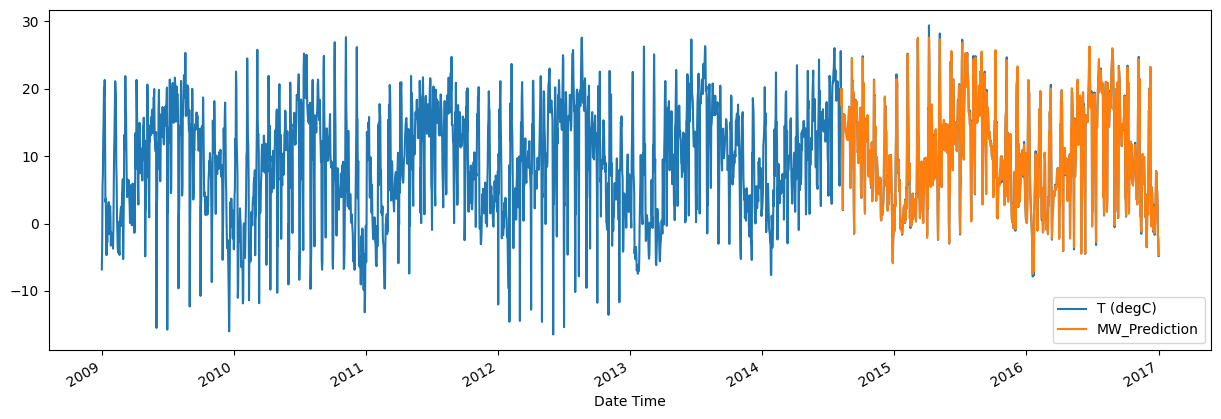

In [91]:
#Comparing the actual and predicted values on the test dataset

split_date = '2014-08-06'
pjme_train = climate_na.loc[climate_na.index <= split_date].copy()
pjme_test = climate_na.loc[climate_na.index > split_date].copy()


pjme_test['MW_Prediction'] = y_pred_test
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)
pjme_all[['T (degC)','MW_Prediction']].plot(figsize=(15, 5))

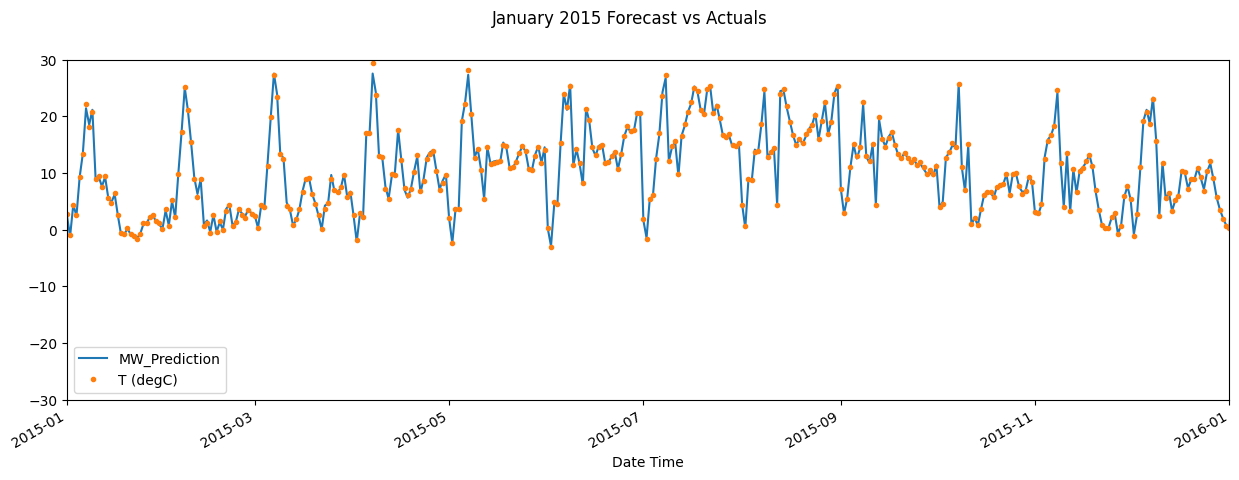

In [92]:
#prediction of 1year data
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','T (degC)']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-01-2016')
ax.set_ylim(-30,30 )
plot = plt.suptitle('January 2015 Forecast vs Actuals')

### Evaluating the base model

* Evaluation metric-RMSE
*  Base metric- Mean of test data

In [93]:
rmse_xgb = sqrt(mean_squared_error(y_test, y_pred_test))
print("XGBoost - Root Mean Square Error (RMSE): %.3f" % rmse_xgb)
print("Mean of y_test",np.mean(y_test))
print("Mean is ",(((np.mean(y_test))/rmse_xgb)*100),'% of y_test')



XGBoost - Root Mean Square Error (RMSE): 0.207
Mean of y_test 10.251750731414418
Mean is  4956.456720507226 % of y_test


## Optimize Hyperparameter

To address the issue of overfitting,we tune the hyperparameter using **optuna**


> Optuna is an automatic hyperparameter optimization software framework (which uses a Bayesian method to find hyperparameters in space), particularly designed for machine learning. Breaking down data into training, validation, and test: X_trainval, X_valid, X_test (this is done for the case when the selection of hyperparameters is required)

In [96]:
def objective(trial):
    boost_round=50
    # Define hyperparameters to be tuned
    param = {
        'objective': 'reg:squarederror',
        'booster': 'gbtree',
        'eval_metric': 'rmse',
        'tree_method': 'hist',
        'grow_policy': 'lossguide',
        'n_jobs': -1,
        'verbosity': 0,
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
    }

    # Perform time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    mse_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Create XGBoost DMatrix
        dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
        dval = xgb.DMatrix(X_val_fold, label=y_val_fold)

        # Train the XGBoost model
        model = xgb.train(param, dtrain, evals=[(dval, 'validation')], early_stopping_rounds=boost_round, verbose_eval=False)
        best_iteration = model.best_iteration

        # Make predictions on the validation set
        #trial.set_user_attr('best_iteration', model.best_iteration)

        y_pred = model.predict(dval)

        mse = mean_squared_error(y_val_fold, y_pred)
        mse_scores.append(mse)


    # Calculate the r2 to compare from the base model to check the overfitting improvement
    r2=r2_score(y_val_fold, y_pred)
    print(r2)
    # Return the average mean squared error as the objective value
    return sum(mse_scores) / len(mse_scores)







In [97]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")





[I 2024-01-27 13:09:50,783] A new study created in memory with name: no-name-9e99abc4-4e11-430b-ab08-ddeda9d51b4f
[I 2024-01-27 13:09:50,880] Trial 0 finished with value: 1.3731649627865214 and parameters: {'booster': 'gbtree', 'learning_rate': 0.25459400349298716, 'max_depth': 14, 'subsample': 0.746575655620535, 'colsample_bytree': 0.6371847023228763, 'lambda': 4.2724179953531936, 'alpha': 4.710804907140019, 'min_child_weight': 3.7385478803190435}. Best is trial 0 with value: 1.3731649627865214.
[I 2024-01-27 13:09:50,938] Trial 1 finished with value: 12.757196302869605 and parameters: {'booster': 'gblinear', 'learning_rate': 0.12149159818398898, 'max_depth': 13, 'subsample': 0.6161587717189019, 'colsample_bytree': 0.6725393808454095, 'lambda': 7.157847587844983, 'alpha': 3.6135290677169385, 'min_child_weight': 1.2847234423956921}. Best is trial 0 with value: 1.3731649627865214.
[I 2024-01-27 13:09:50,990] Trial 2 finished with value: 19.565057676487278 and parameters: {'booster': 'gb

0.9931610185135179
0.8376951512481141
0.7423392099161448
0.9501558934141144


[I 2024-01-27 13:09:51,139] Trial 4 finished with value: 2.347693149572116 and parameters: {'booster': 'gbtree', 'learning_rate': 0.17961377233296216, 'max_depth': 6, 'subsample': 0.9788903491541086, 'colsample_bytree': 0.6216409292155549, 'lambda': 1.6455505126344445, 'alpha': 4.0852861202045885, 'min_child_weight': 4.393608687441706}. Best is trial 0 with value: 1.3731649627865214.
[I 2024-01-27 13:09:51,253] Trial 5 finished with value: 6.589454769925842 and parameters: {'booster': 'dart', 'learning_rate': 0.15716450556693357, 'max_depth': 14, 'subsample': 0.5375355878167956, 'colsample_bytree': 0.8647071273852226, 'lambda': 9.057253369251454, 'alpha': 9.178668905597023, 'min_child_weight': 9.758995622473464}. Best is trial 0 with value: 1.3731649627865214.


0.9758307246093546
0.9470818363672293


[I 2024-01-27 13:09:51,356] Trial 6 finished with value: 13.264788993293797 and parameters: {'booster': 'gbtree', 'learning_rate': 0.09141833984140815, 'max_depth': 6, 'subsample': 0.7885002829920524, 'colsample_bytree': 0.8649359665645067, 'lambda': 3.265433072278504, 'alpha': 5.276798676678371, 'min_child_weight': 8.28517416864755}. Best is trial 0 with value: 1.3731649627865214.
[I 2024-01-27 13:09:51,457] Trial 7 finished with value: 0.47343984065681405 and parameters: {'booster': 'gbtree', 'learning_rate': 0.29745022022134787, 'max_depth': 6, 'subsample': 0.8203575809827897, 'colsample_bytree': 0.848792646143443, 'lambda': 0.4990931072331339, 'alpha': 2.1533216119070433, 'min_child_weight': 8.612349884308536}. Best is trial 7 with value: 0.47343984065681405.
[I 2024-01-27 13:09:51,530] Trial 8 finished with value: 38.83640792486937 and parameters: {'booster': 'gblinear', 'learning_rate': 0.038160180452305195, 'max_depth': 15, 'subsample': 0.5478847483622656, 'colsample_bytree': 0.

0.8354258793141478
0.9971355979118421
0.46055618845143


[I 2024-01-27 13:09:51,632] Trial 9 finished with value: 26.6890733873606 and parameters: {'booster': 'gbtree', 'learning_rate': 0.05403597364642754, 'max_depth': 5, 'subsample': 0.9576232007754873, 'colsample_bytree': 0.5616633001253892, 'lambda': 8.02701512953186, 'alpha': 0.6605810727854738, 'min_child_weight': 4.746772836263476}. Best is trial 7 with value: 0.47343984065681405.
[I 2024-01-27 13:09:51,822] Trial 10 finished with value: 0.5211697835866826 and parameters: {'booster': 'dart', 'learning_rate': 0.2902227791044449, 'max_depth': 3, 'subsample': 0.6809592267036622, 'colsample_bytree': 0.8223933501705751, 'lambda': 0.3195485437932648, 'alpha': 0.005493562960678489, 'min_child_weight': 6.816236022165724}. Best is trial 7 with value: 0.47343984065681405.


0.6389431102992938
0.9951260936099888


[I 2024-01-27 13:09:52,348] Trial 11 finished with value: 0.3987850719088389 and parameters: {'booster': 'dart', 'learning_rate': 0.29068657040274654, 'max_depth': 4, 'subsample': 0.6774356444205509, 'colsample_bytree': 0.8064050117141505, 'lambda': 0.00730388611477828, 'alpha': 0.5492054555765931, 'min_child_weight': 6.107467631054307}. Best is trial 11 with value: 0.3987850719088389.


0.9968857274953001


[I 2024-01-27 13:09:52,862] Trial 12 finished with value: 0.5988787845817887 and parameters: {'booster': 'dart', 'learning_rate': 0.29389820233858477, 'max_depth': 3, 'subsample': 0.6922140471813398, 'colsample_bytree': 0.7750820530556413, 'lambda': 0.03349619335384313, 'alpha': 1.7285136046612877, 'min_child_weight': 6.471671264921692}. Best is trial 11 with value: 0.3987850719088389.


0.9937208382439392


[I 2024-01-27 13:09:53,490] Trial 13 finished with value: 0.9983177157411456 and parameters: {'booster': 'dart', 'learning_rate': 0.23105634970735975, 'max_depth': 8, 'subsample': 0.887472960777792, 'colsample_bytree': 0.9622823218293692, 'lambda': 2.009158357980316, 'alpha': 1.8402970744617646, 'min_child_weight': 8.363758889845938}. Best is trial 11 with value: 0.3987850719088389.


0.9922310111825676


[I 2024-01-27 13:09:53,825] Trial 14 finished with value: 0.8637750937730564 and parameters: {'booster': 'dart', 'learning_rate': 0.262269410744028, 'max_depth': 5, 'subsample': 0.6452502144855498, 'colsample_bytree': 0.7429573155010041, 'lambda': 1.4323626092642074, 'alpha': 1.8139506149301894, 'min_child_weight': 9.799916701391908}. Best is trial 11 with value: 0.3987850719088389.


0.9948294862566562


[I 2024-01-27 13:09:54,246] Trial 15 finished with value: 2.6739569856395073 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2009492150102657, 'max_depth': 7, 'subsample': 0.7498214290562493, 'colsample_bytree': 0.8920750578242849, 'lambda': 6.311313450302713, 'alpha': 2.533864393565424, 'min_child_weight': 5.919618001903406}. Best is trial 11 with value: 0.3987850719088389.


0.9826881664581236


[I 2024-01-27 13:09:54,560] Trial 16 finished with value: 0.5591978689011405 and parameters: {'booster': 'gbtree', 'learning_rate': 0.29811356699827696, 'max_depth': 11, 'subsample': 0.9101581283948885, 'colsample_bytree': 0.7640531846142066, 'lambda': 2.5429037787699142, 'alpha': 0.8383204843763046, 'min_child_weight': 7.538605322738295}. Best is trial 11 with value: 0.3987850719088389.
[I 2024-01-27 13:09:54,728] Trial 17 finished with value: 0.7455125852800853 and parameters: {'booster': 'dart', 'learning_rate': 0.25922929791370775, 'max_depth': 4, 'subsample': 0.8098228445137634, 'colsample_bytree': 0.9190416601108643, 'lambda': 0.8012787195443518, 'alpha': 6.763226258682875, 'min_child_weight': 3.0038354093474338}. Best is trial 11 with value: 0.3987850719088389.


0.9965305743380811
0.9952595857378372


[I 2024-01-27 13:09:54,877] Trial 18 finished with value: 1.8426052257557433 and parameters: {'booster': 'dart', 'learning_rate': 0.22730656639538505, 'max_depth': 7, 'subsample': 0.5832596540787711, 'colsample_bytree': 0.80448655863125, 'lambda': 2.7797301599266038, 'alpha': 9.87992925517188, 'min_child_weight': 5.403022608577127}. Best is trial 11 with value: 0.3987850719088389.
[I 2024-01-27 13:09:54,996] Trial 19 finished with value: 55.77289639250044 and parameters: {'booster': 'gbtree', 'learning_rate': 0.010880433720666438, 'max_depth': 4, 'subsample': 0.7130701706166195, 'colsample_bytree': 0.7349291718606614, 'lambda': 5.4885717930402, 'alpha': 0.05920471824610535, 'min_child_weight': 7.669934830974835}. Best is trial 11 with value: 0.3987850719088389.


0.988914933030094
0.169912246655744


[I 2024-01-27 13:09:55,159] Trial 20 finished with value: 0.7771747427204645 and parameters: {'booster': 'dart', 'learning_rate': 0.2662955143030678, 'max_depth': 8, 'subsample': 0.7855381075871921, 'colsample_bytree': 0.5156700856545007, 'lambda': 0.9495291763343038, 'alpha': 1.2779163932551363, 'min_child_weight': 9.03796130425249}. Best is trial 11 with value: 0.3987850719088389.
[I 2024-01-27 13:09:55,287] Trial 21 finished with value: 0.5192591365581991 and parameters: {'booster': 'dart', 'learning_rate': 0.2831274489822872, 'max_depth': 3, 'subsample': 0.6645827659692964, 'colsample_bytree': 0.8303492299347002, 'lambda': 0.031061815489421326, 'alpha': 0.11745679678510462, 'min_child_weight': 6.974767932379061}. Best is trial 11 with value: 0.3987850719088389.


0.9938654146909445
0.9948774837640697


[I 2024-01-27 13:09:55,422] Trial 22 finished with value: 0.662872438157071 and parameters: {'booster': 'dart', 'learning_rate': 0.2734640988894174, 'max_depth': 3, 'subsample': 0.6573608257404784, 'colsample_bytree': 0.8299500866799263, 'lambda': 0.028688427791288724, 'alpha': 2.588688064877987, 'min_child_weight': 7.538203478333875}. Best is trial 11 with value: 0.3987850719088389.
[I 2024-01-27 13:09:55,585] Trial 23 finished with value: 0.8482024885449165 and parameters: {'booster': 'dart', 'learning_rate': 0.23616436288370957, 'max_depth': 5, 'subsample': 0.6036562760179395, 'colsample_bytree': 0.929385651270843, 'lambda': 1.1349311670776998, 'alpha': 0.5424748656412748, 'min_child_weight': 7.156409034783078}. Best is trial 11 with value: 0.3987850719088389.


0.9937782932295325
0.993615478557811


[I 2024-01-27 13:09:55,749] Trial 24 finished with value: 2.25552333729639 and parameters: {'booster': 'dart', 'learning_rate': 0.18611296572228764, 'max_depth': 4, 'subsample': 0.7226012794979255, 'colsample_bytree': 0.7096322301721502, 'lambda': 2.3547280034699085, 'alpha': 1.3325320943175374, 'min_child_weight': 5.550628471777287}. Best is trial 11 with value: 0.3987850719088389.
[I 2024-01-27 13:09:55,881] Trial 25 finished with value: 0.9862026262339907 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2818805898944143, 'max_depth': 6, 'subsample': 0.6458459581751197, 'colsample_bytree': 0.8541860804859558, 'lambda': 3.4308723967108663, 'alpha': 2.5913412650627623, 'min_child_weight': 6.180195855697832}. Best is trial 11 with value: 0.3987850719088389.


0.9785021982248019
0.9958771160388435


[I 2024-01-27 13:09:56,025] Trial 26 finished with value: 0.7270100333817429 and parameters: {'booster': 'dart', 'learning_rate': 0.2459287533234152, 'max_depth': 4, 'subsample': 0.7758499043544956, 'colsample_bytree': 0.7944368109786084, 'lambda': 0.7527603317637614, 'alpha': 0.8787508470506011, 'min_child_weight': 9.11222295105456}. Best is trial 11 with value: 0.3987850719088389.
[I 2024-01-27 13:09:56,157] Trial 27 finished with value: 1.5916691418900308 and parameters: {'booster': 'dart', 'learning_rate': 0.2111162926855255, 'max_depth': 3, 'subsample': 0.5682619800301247, 'colsample_bytree': 0.8975443578216886, 'lambda': 1.7605876982441624, 'alpha': 3.3899258084283814, 'min_child_weight': 5.0280542031101865}. Best is trial 11 with value: 0.3987850719088389.


0.9940694079707629
0.9866471636552787


[I 2024-01-27 13:09:56,247] Trial 28 finished with value: 4.9724819355796 and parameters: {'booster': 'gblinear', 'learning_rate': 0.14670287872227258, 'max_depth': 5, 'subsample': 0.5072993306220999, 'colsample_bytree': 0.8420533474329758, 'lambda': 0.022266773597432496, 'alpha': 0.06441703520518545, 'min_child_weight': 4.116794974747798}. Best is trial 11 with value: 0.3987850719088389.
[I 2024-01-27 13:09:56,375] Trial 29 finished with value: 1.3344811111613522 and parameters: {'booster': 'gbtree', 'learning_rate': 0.25837907012029965, 'max_depth': 7, 'subsample': 0.7259446973070124, 'colsample_bytree': 0.7124466182396837, 'lambda': 4.201570369870847, 'alpha': 4.221362828271361, 'min_child_weight': 8.25793406053336}. Best is trial 11 with value: 0.3987850719088389.


0.9435661184945927
0.9928004806050365


[I 2024-01-27 13:09:56,518] Trial 30 finished with value: 0.5542815293053496 and parameters: {'booster': 'gbtree', 'learning_rate': 0.27428122143450157, 'max_depth': 12, 'subsample': 0.8378100651239415, 'colsample_bytree': 0.7918906687456639, 'lambda': 0.7914001415323564, 'alpha': 2.1505755533659046, 'min_child_weight': 7.144976754699568}. Best is trial 11 with value: 0.3987850719088389.
[I 2024-01-27 13:09:56,657] Trial 31 finished with value: 0.5023646778344122 and parameters: {'booster': 'dart', 'learning_rate': 0.29864750463542705, 'max_depth': 3, 'subsample': 0.6806609464970019, 'colsample_bytree': 0.8171071288797268, 'lambda': 0.42873460742825986, 'alpha': 0.1468703880415625, 'min_child_weight': 6.609235124948568}. Best is trial 11 with value: 0.3987850719088389.


0.9963426552865009
0.9951823231015813


[I 2024-01-27 13:09:56,814] Trial 32 finished with value: 0.5199881297976838 and parameters: {'booster': 'dart', 'learning_rate': 0.2991609301026445, 'max_depth': 4, 'subsample': 0.6203253892559992, 'colsample_bytree': 0.8812411510253073, 'lambda': 1.3424321027714277, 'alpha': 1.2602395157724704, 'min_child_weight': 5.82962898735083}. Best is trial 11 with value: 0.3987850719088389.
[I 2024-01-27 13:09:56,947] Trial 33 finished with value: 0.7640463878582423 and parameters: {'booster': 'dart', 'learning_rate': 0.2474764329074245, 'max_depth': 3, 'subsample': 0.6789572124764114, 'colsample_bytree': 0.8208225257179892, 'lambda': 0.6747102695906921, 'alpha': 0.544917874818337, 'min_child_weight': 6.346344017609811}. Best is trial 11 with value: 0.3987850719088389.


0.9965456071738347
0.9927809430102494


[I 2024-01-27 13:09:57,045] Trial 34 finished with value: 1.7625402814058853 and parameters: {'booster': 'gblinear', 'learning_rate': 0.27754441603468577, 'max_depth': 5, 'subsample': 0.704870510845933, 'colsample_bytree': 0.9978510429790269, 'lambda': 2.100086078845189, 'alpha': 1.196032283559025, 'min_child_weight': 1.1600799372354986}. Best is trial 11 with value: 0.3987850719088389.
[I 2024-01-27 13:09:57,182] Trial 35 finished with value: 0.8694615228588359 and parameters: {'booster': 'dart', 'learning_rate': 0.2811957796375604, 'max_depth': 4, 'subsample': 0.7548917291952533, 'colsample_bytree': 0.6757038671570625, 'lambda': 4.78022867220095, 'alpha': 0.46987826191773596, 'min_child_weight': 7.888893343512498}. Best is trial 11 with value: 0.3987850719088389.


0.979262119881001
0.9950346025949832


[I 2024-01-27 13:09:57,341] Trial 36 finished with value: 0.9868117529100019 and parameters: {'booster': 'dart', 'learning_rate': 0.2504897083319253, 'max_depth': 6, 'subsample': 0.620952938081452, 'colsample_bytree': 0.7702618028780897, 'lambda': 0.49136431571189554, 'alpha': 5.469459113433574, 'min_child_weight': 7.033516551838919}. Best is trial 11 with value: 0.3987850719088389.
[I 2024-01-27 13:09:57,434] Trial 37 finished with value: 2.600213541326993 and parameters: {'booster': 'gblinear', 'learning_rate': 0.2963351462043274, 'max_depth': 10, 'subsample': 0.8690099234996274, 'colsample_bytree': 0.8495695246897588, 'lambda': 2.971315467659511, 'alpha': 3.2369927608204607, 'min_child_weight': 3.076232587394821}. Best is trial 11 with value: 0.3987850719088389.


0.9924476787340221
0.9678915184771967


[I 2024-01-27 13:09:57,557] Trial 38 finished with value: 6.836895057962967 and parameters: {'booster': 'gbtree', 'learning_rate': 0.11989909990885511, 'max_depth': 3, 'subsample': 0.8157932375531678, 'colsample_bytree': 0.9145966492493056, 'lambda': 1.4010726411871997, 'alpha': 2.1833146800144085, 'min_child_weight': 5.285161444170109}. Best is trial 11 with value: 0.3987850719088389.
[I 2024-01-27 13:09:57,702] Trial 39 finished with value: 2.6210421319340176 and parameters: {'booster': 'dart', 'learning_rate': 0.21135896064330006, 'max_depth': 6, 'subsample': 0.6731388020555492, 'colsample_bytree': 0.7241219759125896, 'lambda': 7.255100930980059, 'alpha': 3.932550972403557, 'min_child_weight': 9.207081332959952}. Best is trial 11 with value: 0.3987850719088389.


0.9133400661737339
0.9832905953070851


[I 2024-01-27 13:09:57,812] Trial 40 finished with value: 2.367683302939959 and parameters: {'booster': 'gblinear', 'learning_rate': 0.24101318872373106, 'max_depth': 8, 'subsample': 0.7345073727727679, 'colsample_bytree': 0.9452567910436068, 'lambda': 1.7549669168117852, 'alpha': 1.5720667208333807, 'min_child_weight': 8.65676945795354}. Best is trial 11 with value: 0.3987850719088389.
[I 2024-01-27 13:09:57,962] Trial 41 finished with value: 0.5193468826970182 and parameters: {'booster': 'dart', 'learning_rate': 0.2987654625278937, 'max_depth': 4, 'subsample': 0.6249586911174598, 'colsample_bytree': 0.883059750660125, 'lambda': 1.2354968561172, 'alpha': 1.0117211168990294, 'min_child_weight': 5.9402559806483834}. Best is trial 11 with value: 0.3987850719088389.


0.9724675311122767
0.996516366576116


[I 2024-01-27 13:09:58,111] Trial 42 finished with value: 0.4324450867600894 and parameters: {'booster': 'dart', 'learning_rate': 0.2808015095621239, 'max_depth': 4, 'subsample': 0.6369536781470103, 'colsample_bytree': 0.8839349617291394, 'lambda': 0.30887588052829895, 'alpha': 0.3094628564660932, 'min_child_weight': 5.982891744362173}. Best is trial 11 with value: 0.3987850719088389.
[I 2024-01-27 13:09:58,274] Trial 43 finished with value: 0.37375382543521507 and parameters: {'booster': 'dart', 'learning_rate': 0.283171549151659, 'max_depth': 5, 'subsample': 0.5859978325509576, 'colsample_bytree': 0.8125620242661868, 'lambda': 0.37489320652113306, 'alpha': 0.07153144062217998, 'min_child_weight': 4.686861708876542}. Best is trial 43 with value: 0.37375382543521507.


0.9964138944829338
0.996994394071382


[I 2024-01-27 13:09:58,419] Trial 44 finished with value: 1.6756887565419247 and parameters: {'booster': 'dart', 'learning_rate': 0.2687476851321152, 'max_depth': 5, 'subsample': 0.5875433282147388, 'colsample_bytree': 0.8082351393987492, 'lambda': 9.894692862719337, 'alpha': 0.4710806069525613, 'min_child_weight': 4.774592637298997}. Best is trial 43 with value: 0.37375382543521507.
[I 2024-01-27 13:09:58,575] Trial 45 finished with value: 0.5182133764023655 and parameters: {'booster': 'dart', 'learning_rate': 0.28330912168947386, 'max_depth': 6, 'subsample': 0.5483180340900542, 'colsample_bytree': 0.862070625733929, 'lambda': 0.4581499791588539, 'alpha': 2.0234861229179204, 'min_child_weight': 3.9846124656283033}. Best is trial 43 with value: 0.37375382543521507.


0.9933530588348165
0.996436973322443


[I 2024-01-27 13:09:58,713] Trial 46 finished with value: 0.8016007939313846 and parameters: {'booster': 'gbtree', 'learning_rate': 0.26161433739593143, 'max_depth': 5, 'subsample': 0.6964054351262893, 'colsample_bytree': 0.7795135877660176, 'lambda': 0.5037032397247105, 'alpha': 5.948328362661439, 'min_child_weight': 3.396719683879402}. Best is trial 43 with value: 0.37375382543521507.
[I 2024-01-27 13:09:58,870] Trial 47 finished with value: 18.563095830340163 and parameters: {'booster': 'dart', 'learning_rate': 0.07123817859997704, 'max_depth': 9, 'subsample': 0.6369036563971008, 'colsample_bytree': 0.751761314522478, 'lambda': 1.8224116038718432, 'alpha': 7.7613879687283776, 'min_child_weight': 4.788898809787817}. Best is trial 43 with value: 0.37375382543521507.


0.9947607900186043
0.7507651177216494


[I 2024-01-27 13:09:59,028] Trial 48 finished with value: 4.066477652154789 and parameters: {'booster': 'dart', 'learning_rate': 0.16115127344293467, 'max_depth': 7, 'subsample': 0.5141550103800614, 'colsample_bytree': 0.8713204185223045, 'lambda': 3.4975125432841736, 'alpha': 0.8475693224658502, 'min_child_weight': 1.8869011319894788}. Best is trial 43 with value: 0.37375382543521507.
[I 2024-01-27 13:09:59,162] Trial 49 finished with value: 0.688375212430898 and parameters: {'booster': 'gbtree', 'learning_rate': 0.28734000978002006, 'max_depth': 4, 'subsample': 0.5667045430375572, 'colsample_bytree': 0.8974298984473544, 'lambda': 1.0699150462401663, 'alpha': 2.9681224398329245, 'min_child_weight': 4.446032577036013}. Best is trial 43 with value: 0.37375382543521507.


0.9612217057235317
0.9965164297459511


[I 2024-01-27 13:09:59,317] Trial 50 finished with value: 1.1264920762731683 and parameters: {'booster': 'dart', 'learning_rate': 0.2233990440006438, 'max_depth': 5, 'subsample': 0.9365556869356754, 'colsample_bytree': 0.8109642228101512, 'lambda': 2.3452093698479883, 'alpha': 1.6431957577259633, 'min_child_weight': 5.686854050755334}. Best is trial 43 with value: 0.37375382543521507.
[I 2024-01-27 13:09:59,471] Trial 51 finished with value: 0.4869227437220496 and parameters: {'booster': 'dart', 'learning_rate': 0.2871975036946449, 'max_depth': 6, 'subsample': 0.5370440101724987, 'colsample_bytree': 0.8622309562146299, 'lambda': 0.40084002370834126, 'alpha': 2.0516684672013046, 'min_child_weight': 3.754552051813359}. Best is trial 43 with value: 0.37375382543521507.


0.9909029469865038
0.9965541287323926


[I 2024-01-27 13:09:59,653] Trial 52 finished with value: 0.4503472437678039 and parameters: {'booster': 'dart', 'learning_rate': 0.2901658496229545, 'max_depth': 6, 'subsample': 0.5320207808757774, 'colsample_bytree': 0.8402419261233197, 'lambda': 0.3248887818929611, 'alpha': 0.3185021751378634, 'min_child_weight': 6.64236005008846}. Best is trial 43 with value: 0.37375382543521507.
[I 2024-01-27 13:09:59,823] Trial 53 finished with value: 0.8643191453165786 and parameters: {'booster': 'dart', 'learning_rate': 0.2691048696570974, 'max_depth': 7, 'subsample': 0.5298534710878906, 'colsample_bytree': 0.8358315826336096, 'lambda': 1.0117673042476003, 'alpha': 4.696882562085299, 'min_child_weight': 2.464223431612191}. Best is trial 43 with value: 0.37375382543521507.


0.997195921628346
0.9946511573562655


[I 2024-01-27 13:09:59,997] Trial 54 finished with value: 0.3809642414904431 and parameters: {'booster': 'dart', 'learning_rate': 0.2878447639729301, 'max_depth': 6, 'subsample': 0.5945546796408879, 'colsample_bytree': 0.9480119335500217, 'lambda': 0.23865391707711245, 'alpha': 0.40981995064168897, 'min_child_weight': 5.133755363991051}. Best is trial 43 with value: 0.37375382543521507.


0.997769264577941
0.9962091281355047


[I 2024-01-27 13:10:00,196] Trial 55 finished with value: 0.4380333328412308 and parameters: {'booster': 'dart', 'learning_rate': 0.25564257553575065, 'max_depth': 8, 'subsample': 0.6079769783478239, 'colsample_bytree': 0.963093986557352, 'lambda': 0.03224557687584639, 'alpha': 0.39861253865026597, 'min_child_weight': 5.255949158922886}. Best is trial 43 with value: 0.37375382543521507.
[I 2024-01-27 13:10:00,389] Trial 56 finished with value: 0.49104741371561056 and parameters: {'booster': 'dart', 'learning_rate': 0.24853848861608657, 'max_depth': 8, 'subsample': 0.5989162752080744, 'colsample_bytree': 0.9722201348464433, 'lambda': 0.11994218293968735, 'alpha': 0.3634733744615092, 'min_child_weight': 5.011074793559939}. Best is trial 43 with value: 0.37375382543521507.
[I 2024-01-27 13:10:00,556] Trial 57 finished with value: 0.7387326656251123 and parameters: {'booster': 'dart', 'learning_rate': 0.25528635961990953, 'max_depth': 9, 'subsample': 0.5666482427368237, 'colsample_bytree':

0.9955769049147861
0.9948744724895492


[I 2024-01-27 13:10:00,722] Trial 58 finished with value: 0.5571948544238943 and parameters: {'booster': 'dart', 'learning_rate': 0.2682738315227723, 'max_depth': 10, 'subsample': 0.6004597291258722, 'colsample_bytree': 0.9840457445190179, 'lambda': 0.9492430733865099, 'alpha': 1.1359175614679482, 'min_child_weight': 5.315201162374296}. Best is trial 43 with value: 0.37375382543521507.


0.9965533851988491


[I 2024-01-27 13:10:00,962] Trial 59 finished with value: 0.5541468041967214 and parameters: {'booster': 'dart', 'learning_rate': 0.2384828966281101, 'max_depth': 15, 'subsample': 0.556833254224924, 'colsample_bytree': 0.9347785180165822, 'lambda': 0.2567831121506712, 'alpha': 0.012995567159487076, 'min_child_weight': 4.485575038701118}. Best is trial 43 with value: 0.37375382543521507.
[I 2024-01-27 13:10:01,125] Trial 60 finished with value: 0.5236588586540603 and parameters: {'booster': 'dart', 'learning_rate': 0.27793173403394805, 'max_depth': 7, 'subsample': 0.5839960468429083, 'colsample_bytree': 0.9623484115298362, 'lambda': 0.757774050474638, 'alpha': 1.437927943751781, 'min_child_weight': 5.113703061270605}. Best is trial 43 with value: 0.37375382543521507.


0.9945729282473645
0.9966419773953209


[I 2024-01-27 13:10:01,315] Trial 61 finished with value: 0.3517196556535963 and parameters: {'booster': 'dart', 'learning_rate': 0.28797256219230055, 'max_depth': 6, 'subsample': 0.6483408159094327, 'colsample_bytree': 0.8986248969051077, 'lambda': 0.013256882225292976, 'alpha': 0.3982642899284565, 'min_child_weight': 6.726590256606723}. Best is trial 61 with value: 0.3517196556535963.
[I 2024-01-27 13:10:01,498] Trial 62 finished with value: 0.4035334663390757 and parameters: {'booster': 'dart', 'learning_rate': 0.28674599675412893, 'max_depth': 6, 'subsample': 0.6533124715675299, 'colsample_bytree': 0.9304210336893519, 'lambda': 0.2966426905850028, 'alpha': 0.38846943604377054, 'min_child_weight': 6.084480645973751}. Best is trial 61 with value: 0.3517196556535963.


0.9978408945565549
0.9977885697871847


[I 2024-01-27 13:10:01,681] Trial 63 finished with value: 0.497735283346731 and parameters: {'booster': 'dart', 'learning_rate': 0.26048484047213555, 'max_depth': 6, 'subsample': 0.6542248425210712, 'colsample_bytree': 0.9169301122871927, 'lambda': 0.1794590173476077, 'alpha': 0.6611874070094834, 'min_child_weight': 6.135734722311733}. Best is trial 61 with value: 0.3517196556535963.
[I 2024-01-27 13:10:01,862] Trial 64 finished with value: 0.33942243635195046 and parameters: {'booster': 'dart', 'learning_rate': 0.28786578709943633, 'max_depth': 5, 'subsample': 0.6305781694965189, 'colsample_bytree': 0.903131474445439, 'lambda': 0.0019964979269903593, 'alpha': 0.894289046690146, 'min_child_weight': 5.623766166859929}. Best is trial 64 with value: 0.33942243635195046.


0.9965564951030859
0.9976101669716916


[I 2024-01-27 13:10:02,042] Trial 65 finished with value: 0.45757870712894055 and parameters: {'booster': 'dart', 'learning_rate': 0.28897764907973883, 'max_depth': 5, 'subsample': 0.6352047778651422, 'colsample_bytree': 0.9089386193331388, 'lambda': 0.668622982081228, 'alpha': 0.9091850688485023, 'min_child_weight': 5.6217099314832195}. Best is trial 64 with value: 0.33942243635195046.
[I 2024-01-27 13:10:02,203] Trial 66 finished with value: 1.0312793311410138 and parameters: {'booster': 'dart', 'learning_rate': 0.2726758088086919, 'max_depth': 4, 'subsample': 0.6598676400788296, 'colsample_bytree': 0.932541677935044, 'lambda': 5.669710911380681, 'alpha': 1.0836002494758392, 'min_child_weight': 7.361032007350146}. Best is trial 64 with value: 0.33942243635195046.


0.9974566467765801
0.9951776492249323


[I 2024-01-27 13:10:02,363] Trial 67 finished with value: 0.8643323354398411 and parameters: {'booster': 'dart', 'learning_rate': 0.2773391621838814, 'max_depth': 5, 'subsample': 0.6384161115739349, 'colsample_bytree': 0.900792689560723, 'lambda': 1.1074602081087865, 'alpha': 8.145026839412644, 'min_child_weight': 6.7578449411649775}. Best is trial 64 with value: 0.33942243635195046.
[I 2024-01-27 13:10:02,532] Trial 68 finished with value: 10.514800684659315 and parameters: {'booster': 'dart', 'learning_rate': 0.11315741079722239, 'max_depth': 5, 'subsample': 0.691445794511496, 'colsample_bytree': 0.9445128744592282, 'lambda': 8.255767220432165, 'alpha': 1.7141635545000358, 'min_child_weight': 6.3791159586046255}. Best is trial 64 with value: 0.33942243635195046.


0.9960349332592205
0.8871516421590329


[I 2024-01-27 13:10:02,645] Trial 69 finished with value: 1.4224713893873295 and parameters: {'booster': 'gblinear', 'learning_rate': 0.2913230970940081, 'max_depth': 4, 'subsample': 0.614592172613315, 'colsample_bytree': 0.8754239430504286, 'lambda': 1.6107087141746144, 'alpha': 0.7022202774045612, 'min_child_weight': 5.979112204151946}. Best is trial 64 with value: 0.33942243635195046.
[I 2024-01-27 13:10:02,834] Trial 70 finished with value: 0.7162428156274909 and parameters: {'booster': 'dart', 'learning_rate': 0.23174994521070763, 'max_depth': 7, 'subsample': 0.66613197111057, 'colsample_bytree': 0.924818791915029, 'lambda': 0.736768848714721, 'alpha': 0.002677189110477818, 'min_child_weight': 5.48560239405647}. Best is trial 64 with value: 0.33942243635195046.


0.9832958709874953
0.9933210182186717


[I 2024-01-27 13:10:03,038] Trial 71 finished with value: 0.4036424289978525 and parameters: {'booster': 'dart', 'learning_rate': 0.2641036418415751, 'max_depth': 6, 'subsample': 0.605341501953683, 'colsample_bytree': 0.9968732463321694, 'lambda': 0.05949023408534279, 'alpha': 0.4449499880699448, 'min_child_weight': 5.807654475789602}. Best is trial 64 with value: 0.33942243635195046.
[I 2024-01-27 13:10:03,227] Trial 72 finished with value: 0.37228796339991393 and parameters: {'booster': 'dart', 'learning_rate': 0.26650761098264975, 'max_depth': 6, 'subsample': 0.5838362495327412, 'colsample_bytree': 0.992790593751853, 'lambda': 0.02404700844164514, 'alpha': 0.2635635063270748, 'min_child_weight': 5.755413142653569}. Best is trial 64 with value: 0.33942243635195046.


0.996744349134183
0.9969330232909641


[I 2024-01-27 13:10:03,397] Trial 73 finished with value: 0.45674835505933337 and parameters: {'booster': 'dart', 'learning_rate': 0.2645487569143481, 'max_depth': 6, 'subsample': 0.583714956108173, 'colsample_bytree': 0.9991815638902256, 'lambda': 0.015719717662301815, 'alpha': 1.4444444329125588, 'min_child_weight': 5.715611412432806}. Best is trial 64 with value: 0.33942243635195046.
[I 2024-01-27 13:10:03,571] Trial 74 finished with value: 0.439047024024153 and parameters: {'booster': 'dart', 'learning_rate': 0.289165635018629, 'max_depth': 6, 'subsample': 0.6040810118951068, 'colsample_bytree': 0.978558278466682, 'lambda': 0.5675674752270643, 'alpha': 0.6500437508983286, 'min_child_weight': 6.453489298887811}. Best is trial 64 with value: 0.33942243635195046.


0.9964062201886453
0.9971436329763788


[I 2024-01-27 13:10:03,741] Trial 75 finished with value: 0.3716362639767901 and parameters: {'booster': 'dart', 'learning_rate': 0.27297421590816584, 'max_depth': 5, 'subsample': 0.9973889747416025, 'colsample_bytree': 0.9869266262372193, 'lambda': 0.9186565938422272, 'alpha': 0.2615930503420928, 'min_child_weight': 4.152023637260539}. Best is trial 64 with value: 0.33942243635195046.
[I 2024-01-27 13:10:03,930] Trial 76 finished with value: 0.4227433099829697 and parameters: {'booster': 'dart', 'learning_rate': 0.2995457626756331, 'max_depth': 7, 'subsample': 0.6524166641294047, 'colsample_bytree': 0.9491950728840027, 'lambda': 1.2640080956272635, 'alpha': 1.0132817599362665, 'min_child_weight': 4.5346590421489}. Best is trial 64 with value: 0.33942243635195046.


0.9968814818013131
0.9977146088309942


[I 2024-01-27 13:10:04,109] Trial 77 finished with value: 0.5141071151466595 and parameters: {'booster': 'dart', 'learning_rate': 0.2757863106229174, 'max_depth': 5, 'subsample': 0.7651854441238061, 'colsample_bytree': 0.984391660539291, 'lambda': 2.057840448389633, 'alpha': 0.24729455095192704, 'min_child_weight': 4.978480454919316}. Best is trial 64 with value: 0.33942243635195046.
[I 2024-01-27 13:10:04,290] Trial 78 finished with value: 1.8404374362498064 and parameters: {'booster': 'dart', 'learning_rate': 0.18397259022465062, 'max_depth': 14, 'subsample': 0.9578781529701026, 'colsample_bytree': 0.6867150759718675, 'lambda': 0.922751203446535, 'alpha': 1.3686055897084701, 'min_child_weight': 3.925106912088408}. Best is trial 64 with value: 0.33942243635195046.


0.9966260454466602
0.979471792823466


[I 2024-01-27 13:10:04,386] Trial 79 finished with value: 2.4042741336084212 and parameters: {'booster': 'gblinear', 'learning_rate': 0.24478576426470622, 'max_depth': 5, 'subsample': 0.7124905478668699, 'colsample_bytree': 0.9766457501863026, 'lambda': 0.5417672981820344, 'alpha': 2.4019271704140257, 'min_child_weight': 4.20638751145373}. Best is trial 64 with value: 0.33942243635195046.


0.9713763619390843


[I 2024-01-27 13:10:04,606] Trial 80 finished with value: 0.3939773245730808 and parameters: {'booster': 'dart', 'learning_rate': 0.28245472559349655, 'max_depth': 7, 'subsample': 0.7991621102673363, 'colsample_bytree': 0.6277427642381616, 'lambda': 0.34325754887847015, 'alpha': 0.6724509137739322, 'min_child_weight': 4.678424237614628}. Best is trial 64 with value: 0.33942243635195046.


0.9966103970208361


[I 2024-01-27 13:10:05,288] Trial 81 finished with value: 0.32829760718189477 and parameters: {'booster': 'dart', 'learning_rate': 0.28463448511374323, 'max_depth': 7, 'subsample': 0.9003977325000928, 'colsample_bytree': 0.958729382087233, 'lambda': 0.3122893982137924, 'alpha': 0.6867945642614249, 'min_child_weight': 3.4536073421917486}. Best is trial 81 with value: 0.32829760718189477.


0.9974700864000121


[I 2024-01-27 13:10:05,894] Trial 82 finished with value: 0.42079332385964213 and parameters: {'booster': 'dart', 'learning_rate': 0.27261615319549676, 'max_depth': 8, 'subsample': 0.9957085766985144, 'colsample_bytree': 0.6123879876075223, 'lambda': 0.6725197213638469, 'alpha': 0.7183902708136831, 'min_child_weight': 3.6072016155738016}. Best is trial 81 with value: 0.32829760718189477.


0.9964189564413474


[I 2024-01-27 13:10:06,897] Trial 83 finished with value: 0.357271692995382 and parameters: {'booster': 'dart', 'learning_rate': 0.2933905706529201, 'max_depth': 7, 'subsample': 0.9011654008314914, 'colsample_bytree': 0.6303656059068355, 'lambda': 0.29634345022601616, 'alpha': 1.1023347870997673, 'min_child_weight': 3.4487233841893628}. Best is trial 81 with value: 0.32829760718189477.


0.9969057284310765


[I 2024-01-27 13:10:07,297] Trial 84 finished with value: 0.4285947601590415 and parameters: {'booster': 'dart', 'learning_rate': 0.2932476957936919, 'max_depth': 7, 'subsample': 0.9315452888607479, 'colsample_bytree': 0.6270953676566633, 'lambda': 1.233269847279418, 'alpha': 1.1164616428473955, 'min_child_weight': 3.178951870473422}. Best is trial 81 with value: 0.32829760718189477.
[I 2024-01-27 13:10:07,487] Trial 85 finished with value: 0.3731812119167567 and parameters: {'booster': 'dart', 'learning_rate': 0.2820569461813658, 'max_depth': 7, 'subsample': 0.8952975084682178, 'colsample_bytree': 0.5605152849019734, 'lambda': 0.8687538463921461, 'alpha': 0.17228085598061352, 'min_child_weight': 2.70510486448351}. Best is trial 81 with value: 0.32829760718189477.


0.9968027683542257
0.9966843941080034


[I 2024-01-27 13:10:07,688] Trial 86 finished with value: 0.6401072949330088 and parameters: {'booster': 'dart', 'learning_rate': 0.2526883020460984, 'max_depth': 8, 'subsample': 0.8926903459585097, 'colsample_bytree': 0.5456937168855948, 'lambda': 0.926474590976404, 'alpha': 0.19719390020487157, 'min_child_weight': 2.7490025309410715}. Best is trial 81 with value: 0.32829760718189477.
[I 2024-01-27 13:10:07,864] Trial 87 finished with value: 0.45981861480567954 and parameters: {'booster': 'dart', 'learning_rate': 0.2806623397853843, 'max_depth': 6, 'subsample': 0.8419231830389372, 'colsample_bytree': 0.6047252774066265, 'lambda': 1.4866340527941018, 'alpha': 0.1859064146619037, 'min_child_weight': 2.1559699417940434}. Best is trial 81 with value: 0.32829760718189477.


0.9937506249480681
0.9963116598316144


[I 2024-01-27 13:10:08,067] Trial 88 finished with value: 0.3379674215549978 and parameters: {'booster': 'dart', 'learning_rate': 0.2999709259666927, 'max_depth': 7, 'subsample': 0.8594128641742964, 'colsample_bytree': 0.5750374173599543, 'lambda': 0.5962666951815514, 'alpha': 0.9757221631336754, 'min_child_weight': 3.371495771364855}. Best is trial 81 with value: 0.32829760718189477.
[I 2024-01-27 13:10:08,251] Trial 89 finished with value: 53.921368607092234 and parameters: {'booster': 'dart', 'learning_rate': 0.01148947659200561, 'max_depth': 7, 'subsample': 0.8673821726875703, 'colsample_bytree': 0.5805210648091226, 'lambda': 0.579682316185468, 'alpha': 1.7626355954035682, 'min_child_weight': 3.4204585496275204}. Best is trial 81 with value: 0.32829760718189477.


0.9971302314941567
0.18953520687322223


[I 2024-01-27 13:10:08,440] Trial 90 finished with value: 0.9962469659503039 and parameters: {'booster': 'dart', 'learning_rate': 0.29440029218231173, 'max_depth': 8, 'subsample': 0.9002301968845758, 'colsample_bytree': 0.5248623661723467, 'lambda': 6.637419395846428, 'alpha': 0.8442890456486365, 'min_child_weight': 2.4289785293409136}. Best is trial 81 with value: 0.32829760718189477.
[I 2024-01-27 13:10:08,624] Trial 91 finished with value: 0.4380206864176993 and parameters: {'booster': 'dart', 'learning_rate': 0.2724352527795327, 'max_depth': 6, 'subsample': 0.9225742586477557, 'colsample_bytree': 0.6469165595377846, 'lambda': 0.8119475283244154, 'alpha': 0.5256460698736622, 'min_child_weight': 3.271575338211545}. Best is trial 81 with value: 0.32829760718189477.


0.9935918398821424
0.9962488672835502


[I 2024-01-27 13:10:08,828] Trial 92 finished with value: 0.32790636987481103 and parameters: {'booster': 'dart', 'learning_rate': 0.2993862997924076, 'max_depth': 7, 'subsample': 0.8705482978149743, 'colsample_bytree': 0.5714858309951167, 'lambda': 0.2572422906220544, 'alpha': 0.9489225790799405, 'min_child_weight': 4.223368350058116}. Best is trial 92 with value: 0.32790636987481103.
[I 2024-01-27 13:10:09,009] Trial 93 finished with value: 0.4276409907931358 and parameters: {'booster': 'dart', 'learning_rate': 0.29977087134337344, 'max_depth': 7, 'subsample': 0.8580569712923583, 'colsample_bytree': 0.5687248043657581, 'lambda': 1.1292185015682246, 'alpha': 1.2377052503651045, 'min_child_weight': 2.876426325359535}. Best is trial 92 with value: 0.32790636987481103.


0.9974232969768106
0.9969515499229462


[I 2024-01-27 13:10:09,213] Trial 94 finished with value: 0.39481317758331647 and parameters: {'booster': 'dart', 'learning_rate': 0.2832464714389966, 'max_depth': 7, 'subsample': 0.9501185290119709, 'colsample_bytree': 0.5860596785854271, 'lambda': 0.42594879554013315, 'alpha': 0.933494102835277, 'min_child_weight': 4.191689558534576}. Best is trial 92 with value: 0.32790636987481103.
[I 2024-01-27 13:10:09,384] Trial 95 finished with value: 0.6366751958825122 and parameters: {'booster': 'dart', 'learning_rate': 0.2930008565482759, 'max_depth': 8, 'subsample': 0.8796653799524251, 'colsample_bytree': 0.5510853944361878, 'lambda': 1.8463435440048235, 'alpha': 1.9223746287419718, 'min_child_weight': 3.6380566920754736}. Best is trial 92 with value: 0.32790636987481103.


0.9967317694994854
0.9943988811915677


[I 2024-01-27 13:10:09,558] Trial 96 finished with value: 0.5426504398205128 and parameters: {'booster': 'dart', 'learning_rate': 0.27050965212531075, 'max_depth': 7, 'subsample': 0.8291861091822081, 'colsample_bytree': 0.5090611485416252, 'lambda': 0.2828636167206527, 'alpha': 1.480209482807906, 'min_child_weight': 3.8914527658405857}. Best is trial 92 with value: 0.32790636987481103.
[I 2024-01-27 13:10:09,661] Trial 97 finished with value: 1.4401828390901275 and parameters: {'booster': 'gblinear', 'learning_rate': 0.26425997611959645, 'max_depth': 5, 'subsample': 0.9082756266713127, 'colsample_bytree': 0.5360376243405887, 'lambda': 0.9115412044431022, 'alpha': 0.1828701008803143, 'min_child_weight': 3.459495004845307}. Best is trial 92 with value: 0.32790636987481103.


0.9948490798869274
0.9833899114042969


[I 2024-01-27 13:10:09,853] Trial 98 finished with value: 0.29533459552784624 and parameters: {'booster': 'dart', 'learning_rate': 0.27716309835132663, 'max_depth': 6, 'subsample': 0.9767608463736079, 'colsample_bytree': 0.5974772860863877, 'lambda': 0.23435495373195922, 'alpha': 0.006720176745556361, 'min_child_weight': 1.614111414555854}. Best is trial 98 with value: 0.29533459552784624.
[I 2024-01-27 13:10:10,043] Trial 99 finished with value: 0.3319588667599448 and parameters: {'booster': 'dart', 'learning_rate': 0.2767942255260836, 'max_depth': 13, 'subsample': 0.9942189276654838, 'colsample_bytree': 0.5961052776818714, 'lambda': 0.0015815955392557337, 'alpha': 1.2042043976949215, 'min_child_weight': 1.792314950287948}. Best is trial 98 with value: 0.29533459552784624.


0.9969042225989396
0.9965177686288559
Best hyperparameters: {'booster': 'dart', 'learning_rate': 0.27716309835132663, 'max_depth': 6, 'subsample': 0.9767608463736079, 'colsample_bytree': 0.5974772860863877, 'lambda': 0.23435495373195922, 'alpha': 0.006720176745556361, 'min_child_weight': 1.614111414555854}


In [98]:
best_param = study.best_params
dtrain_full = xgb.DMatrix(X_train, label=y_train)
final_model = xgb.train(best_param, dtrain_full,num_boost_round=100)




In [99]:
X_test_dmatrix = xgb.DMatrix(data=X_test)
y_pred_final = final_model.predict(X_test_dmatrix)
rmse_score=sqrt(mean_squared_error(y_test, y_pred_final))
r2_final=r2_score(y_test, y_pred_final)
print(rmse_score)
print(r2_final)


0.2137540631397793
0.9991176776653774


The r2 score has reduced for the train test and r2 score for test is greater than train test,that indicates **overfitting is reduced** to some extent.
But the **RMSE increased** to 0.213 from 0.207.
The **R2 score decreased** to 0.9965177 from 0.9999733 for the train dataset.While the r2 score of the test dataset remained more or less the same.
* These two observations could be due to a trade-off between bias and variance in your model.
* While a decrease in R2 may suggest a more generalizable model, the increase in RMSE indicates a decrease in prediction accuracy.